In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [1]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import numpy as np
import gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import TensorBoard
import random
from collections import deque
import pandas as pd
from tqdm import tqdm
import time as time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

     |████████████████████████████████| 450kB 29.9MB/s 


In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
class DQN():
    
    def __init__(self, game, retrain = False, epsilon=1, epsilon_decay = 0.995, 
                 epsilon_min = 0.1, batch_size = 64, discount_factor=0.99, episodes=1000, alpha = 0.01, lr=0.001):
        
        self.ep = epsilon
        self.ep_decay = epsilon_decay
        self.ep_min = epsilon_min
        self.batch_size = batch_size
        self.gamma = discount_factor
        self.episodes = episodes
        self.game = game
        self.alpha = alpha
        self.lr = lr
        self.retrain = retrain
        
        self.frames = []
        
        seed = 983827
        mem = 1000000

        self.csv_filename = "/content/drive/MyDrive/Colab Notebooks/DQN-FinalFrontier/1.0_0.0001/1p0_0p0001.csv"
        self.model_filename = "/content/drive/MyDrive/Colab Notebooks/DQN-FinalFrontier/1.0_0.0001/1p0_0p0001.h5"

        
        self.env = gym.make(game)
        self.env.seed(seed)
        
        keras.backend.clear_session()
        
        tf.random.set_seed(seed)
        np.random.seed(seed)
        
        self.nS = self.env.observation_space.shape[0]
        self.nA = self.env.action_space.n
        
        print("state size is: ",self.nS)
        print("action size is: ", self.nA)
       
        
        self.memory = deque(maxlen=1000000)  #Creating a container to replay meomory, double linked list.

        if self.retrain == False:
          self.Q_model = self.setup_dnn()
          self.Q_hat_model = self.setup_dnn()
          print("NEW MODEL CREATED!")
        
        else:

          self.Q_model = tf.keras.models.load_model(self.model_filename)
          self.Q_hat_model = tf.keras.models.load_model(self.model_filename)
          print("MODEL LOADED!")
          self.Q_model.summary()


        self.counter = 0
        self.update_freq = 4

        
        self.df_ddqn = pd.DataFrame(columns = ["Episode", "Epsilon", "Reward", "Mean_Reward", "Time"])
        
    def setup_dnn(self):
        
        input_ = tf.keras.layers.Input(shape = (self.nS))
        
        hidden1_ = tf.keras.layers.Dense(64, activation = "relu")(input_)
        hidden2_ = tf.keras.layers.Dense(64, activation = "relu")(hidden1_)
        output_ = tf.keras.layers.Dense(self.nA)(hidden2_)
        
        model_ = tf.keras.Model(inputs = [input_], outputs = [output_])
        opt_ = tf.keras.optimizers.Adam(self.lr)
        model_.compile(optimizer = opt_, loss = "mse")
        
        return model_
    
    def action(self, state, epsilon):
        
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        else:
            Q_values = self.Q_model.predict(state) #Greedy policy w.r.t Q
            
        return np.argmax(Q_values[0])
    
    
    def store(self, state, action, reward, next_state, done):
        
        self.memory.append((state, action, reward, next_state, done))
        
    
    def weights_update(self):
        Q_w = self.Q_model.get_weights()
        Q_hat_w = self.Q_hat_model.get_weights()
        
        for w in range(len(Q_hat_w)):
            Q_hat_w[w] = self.alpha * Q_w[w] + (1-self.alpha) * Q_hat_w[w]
        
        self.Q_hat_model.set_weights(Q_hat_weights)
        

    '''
        
    def learn(self):
        
        if self.ep > self.ep_min:
            self.ep *= self.ep_decay
        
        samples = random.choices(self.memory, k = self.batch_size)
        
        for state, action, reward, next_state, done in samples:
            target = reward
            
            if not done:
                target = reward + self.gamma*np.max(self.model.predict(next_state)[0])
            
            end_target = self.model.predict(state)
            end_target[0][action] = target
            
            self.history = self.model.fit(state, end_target, verbose = 0)
    '''
    
    def learn_batch(self):
             
        self.counter = (self.counter + 1) % self.update_freq
        
        if self.counter == 0:
            #print("Learning...")
            if len(self.memory) < self.batch_size:
                return
            
            states, end_targets = [], []
            
            samples = random.choices(self.memory, k = self.batch_size)
            
            for state, action, reward, next_state, done in samples:
                target = reward
            
                if not done:
                    target = reward + self.gamma*np.max(self.Q_hat_model.predict(next_state)[0])
            
                end_target = self.Q_model.predict(state)
                end_target[0][action] = target
                
                states.append(state[0])
                end_targets.append(end_target[0])
            
            self.Q_model.fit(np.array(states), np.array(end_targets), verbose = 0, epochs = 1)
            
            Q_w = self.Q_model.get_weights()
            Q_hat_w = self.Q_hat_model.get_weights()
        
            for w in range(len(Q_hat_w)):
                Q_hat_w[w] = self.alpha * Q_w[w] + (1-self.alpha) * Q_hat_w[w]
        
            self.Q_hat_model.set_weights(Q_hat_w)
    
    
    def play(self): 
        
        new_row = {}
        R = []
        R_moving = deque(maxlen=100)
        steps = 500
        
        for e in range(self.episodes):
            current_state = self.env.reset()
            current_state = np.reshape(current_state, [1,current_state.shape[0]])
         
            time = 0
            r = 0
            
            for s in range(steps):

                action_ = self.action(current_state, self.ep)
               
                next_state, reward, done, info = self.env.step(action_)
                
                next_state = np.reshape(next_state, [1, next_state.shape[0]])
                
                self.store(current_state, action_, reward, next_state, done)
                
                r = r+reward
                
                #self.learn()
                self.learn_batch()
                
                current_state = next_state
                time = time+1
                
                if done:
                    break
            
            #self.learn_batch()
            R.append(r)
            R_moving.append(r)

                    
            new_row = {'Episode':e, 'Epsilon':self.ep, 'Reward': r, 'Mean_Reward':np.mean(R_moving), 'Time':time}
            self.df_ddqn = self.df_ddqn.append(new_row, ignore_index = True)
            
            
            if e % 5 == 0:
              print("Episode: ", e, " , Epsilon: ", self.ep, ', Reward', r,", mean_reward: ",np.mean(R_moving) ,", time_score: ", time, ", memory: ", len(self.memory))

            if e % 100 == 0:

              self.Q_model.save(self.model_filename)
              

            if self.ep > self.ep_min:
              self.ep *= self.ep_decay
            else:
              self.ep = 0.01
            
            if np.mean(R_moving)>= 200.0:
                print("BRAVO, GOAL ACHIEVED!!!")
                break

        with open(self.csv_filename, 'a') as f:
          self.df_ddqn.to_csv(f, header=f.tell()==0, index=False)
             
            
        self.Q_model.save(self.model_filename)
        
        self.env.close()
        
        return self.df_ddqn
   

In [4]:
game = "LunarLander-v2"
dqn = DQN(game, retrain = False, epsilon=1 , epsilon_decay = 0.995, epsilon_min = 0.01, batch_size = 64, discount_factor=0.99, episodes=2000, alpha = 1.0, lr=0.0001)
df = dqn.play()

state size is:  8
action size is:  4
NEW MODEL CREATED!


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode:  0  , Epsilon:  1 , Reward -224.7494971767204 , mean_reward:  -224.7494971767204 , time_score:  78 , memory:  78
Episode:  5  , Epsilon:  0.9752487531218751 , Reward -70.95539540793285 , mean_reward:  -173.02710592238006 , time_score:  98 , memory:  527
Episode:  10  , Epsilon:  0.9511101304657719 , Reward -297.57451940708074 , mean_reward:  -209.10014786559188 , time_score:  87 , memory:  1006
Episode:  15  , Epsilon:  0.9275689688183278 , Reward -95.80862284582048 , mean_reward:  -198.62354049338904 , time_score:  130 , memory:  1522
Episode:  20  , Epsilon:  0.9046104802746175 , Reward -159.19680131116775 , mean_reward:  -184.33969188429583 , time_score:  168 , memory:  2128
Episode:  25  , Epsilon:  0.8822202429488013 , Reward -93.51260145485222 , mean_reward:  -194.1908754102614 , time_score:  69 , memory:  2635
Episode:  30  , Epsilon:  0.8603841919146962 , Reward -105.09876093836256 , mean_reward:  -187.6251487884924 , time_score:  71 , memory:  3176
Episode:  35  , Eps

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

def test(saved_model):    
    
    # Keras load trained agent
    model = tf.keras.models.load_model(saved_model)
    
    # summary of the value-action model Q
    model.summary()
    
    # plot model structure
    plot_model(model, show_shapes = True, to_file='model.png')
    print("model weights:", model.get_weights()) 
   
    # test the trained agent
    env = gym.make("LunarLander-v2")
    scores = []
    
    # run the trained agent 100 trials
    for trial in range(100):
        score = 0
        cur_state = env.reset().reshape(1,8)
        for step in range(1000):
            #env.render()
            action = np.argmax(model.predict(cur_state)[0])
            new_state, reward, done, _ = env.step(action)
            new_state = new_state.reshape(1,8)
            score += reward
            cur_state = new_state
            if done:
                break   
        
        scores.append(score)
        print('\rtrial {}\t Score: {:.3f}'.format(trial, (score)), end="")
              
    env.close()
    
    return scores

In [ ]:
s = test("/content/drive/MyDrive/Colab Notebooks/DQN-FinalFrontier/1.0_0.0001/1p0_0p0001.h5")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 4,996
Trainable params: 4,996
Non-trainable params: 0
_________________________________________________________________
model weights: [array([[ 4.11513634e-02,  2.13329092e-01,  1.22493312e-01,
         3.02145004e-01,  2.10580260e-01,  5.23118258e-01,
         4.64310013e-02, -8.38390648e-01, -1.37781411e-01,
        -5.55888772e-01,  3.82250994e-01, -6.21847548e-02,
     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


trial 99	 Score: 29.684

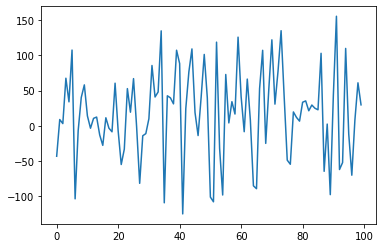

In [ ]:
plt.plot(np.arange(len(s)), s)

In [ ]:
np.mean(s)

17.5526554011553